In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

telco_customer = pd.read_csv('Telco_resampled.csv')

In [2]:
telco_customer.head()

,tenure,MonthlyCharges,TotalCharges,internet_cnt,Contract,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,1,29.85,29.85,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,0,1,0
1,34,56.95,1889.50,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,1,0,0
2,45,42.30,1840.75,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0
3,22,89.10,1949.40,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,1,1,0
4,10,29.75,301.90,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0


## 변수 처리

### 변수 나누기

In [3]:
telco_customer.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'internet_cnt', 'Contract',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn'],
      dtype='object')

In [4]:
numeric_df = telco_customer[['tenure', 'MonthlyCharges', 'TotalCharges', 'internet_cnt']]
category_df = telco_customer[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'PaperlessBilling', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']]
time_df = telco_customer[['Contract']]
y_column = telco_customer['Churn']

### Scaling 진행

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# 데이터에 fit하고 transform 수행
numeric_scaled = scaler.fit_transform(numeric_df)
numeric_df_scaled = pd.DataFrame(numeric_scaled, columns=scaler.get_feature_names_out())

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 데이터에 fit하고 transform 수행
numeric_scaled = scaler.fit_transform(numeric_df)
numeric_df_scaled = pd.DataFrame(numeric_scaled, columns=scaler.get_feature_names_out())

In [7]:
numeric_df_scaled

,tenure,MonthlyCharges,TotalCharges,internet_cnt
0,-1.108986,-1.314349,-0.915438,0.652119
1,0.259141,-0.373105,-0.067237,0.652119
2,0.715183,-0.881933,-0.089473,0.652119
3,-0.238360,0.743539,-0.039917,0.652119
4,-0.735860,-1.317823,-0.791354,0.652119
...,...,...,...,...
10321,0.051849,1.073495,0.408802,0.652119
10322,-0.652943,0.368430,-0.514337,0.652119
10323,-0.984611,0.210398,-0.780612,0.652119
10324,1.295601,1.104754,1.789850,0.652119


## 상관관계 파악

### 로지스틱 회귀로 연속형 변수의 상관관계 파악

In [8]:
# 모든 상관관계를 한번에 보기 위해 독립변수들 먼저 모으기
X = pd.concat([y_column, numeric_df_scaled, category_df, time_df], axis=1)

In [9]:
# 크래머V 사용
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

In [10]:
# 상관관계 파악을 위한 크래머V 사용
columns = X.columns
corr = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            corr.loc[col1, col2] = cramers_v(X[col1], X[col2])
        else:
            corr.loc[col1, col2] = 1.0

# corr

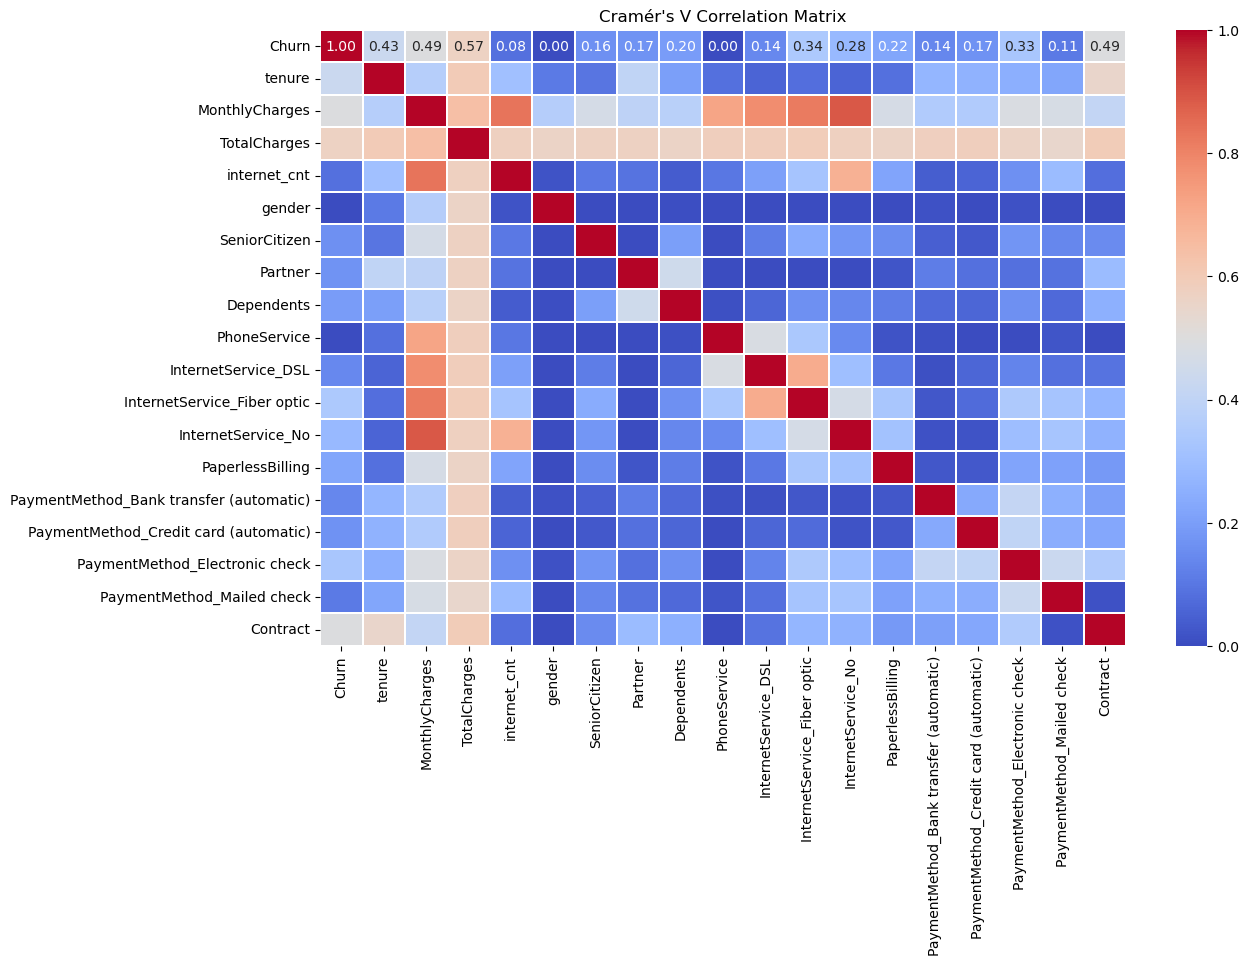

In [11]:
plt.figure(figsize=(13, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.1)
plt.title('Cramér\'s V Correlation Matrix')
plt.show()

#### 크래머V 상관관계 기준
- 0.1 미만: 매우 약한 연관성
- 0.1 - 0.2: 약한 연관성
- 0.2 - 0.4: 중간 정도의 연관성
- 0.4 - 0.6: 강한 연관성
- 0.6 이상: 매우 강한 연관성

In [12]:
# 상관관계에 따른 독립변수 리스트 - 시리즈 타입
# 중간부터
corr_list = corr['Churn'].sort_values(ascending=False)[1:]
val = np.where(corr_list >= 0.4)[0][-1]

corr_val = corr.loc[:corr.columns[val]][1:]
valuable_list = list(corr_val.index)
valuable_list.append('Contract')
print(corr_list)
print(valuable_list)

TotalCharges                               0.569932
MonthlyCharges                             0.493736
Contract                                   0.492808
tenure                                     0.430164
InternetService_Fiber optic                0.342383
PaymentMethod_Electronic check             0.330252
InternetService_No                         0.282629
PaperlessBilling                           0.222099
Dependents                                 0.195008
Partner                                    0.169126
PaymentMethod_Credit card (automatic)      0.166931
SeniorCitizen                              0.161662
InternetService_DSL                        0.141003
PaymentMethod_Bank transfer (automatic)    0.137789
PaymentMethod_Mailed check                 0.105501
internet_cnt                               0.082815
PhoneService                               0.003774
gender                                     0.000000
Name: Churn, dtype: float64
['tenure', 'MonthlyCharges', 'TotalC

## 모델링

In [13]:
# 데이터 분할 -> 나중에 적용할 때 팀이 같은 데이터 분할이 적용되도록 해야하나 생각(물어보기)
from sklearn.model_selection import train_test_split

# valuable_list로 크래머V 기준 몇 개를 사용할 지 조정 후 추림
X_ = X[['tenure', 'Contract', 'PhoneService', 'InternetService_Fiber optic', 'InternetService_No', 'TotalCharges', 'PaperlessBilling', 'MonthlyCharges']]
y = y_column
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)

### 로지스틱 회귀분석 모델

#### 하이퍼 파라미터
- penalty
- C

In [14]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(solver='lbfgs', penalty='l2', C=3.646, max_iter=1000)
logistic_reg.fit(X_train, y_train)

# 학습된 모델의 계수(coefficients) 및 절편(intercept) 출력
coefficients = logistic_reg.coef_
intercept = logistic_reg.intercept_

print('#'*20, '학습된 파라미터 값', '#'*20)
print(coefficients)

print('#'*20, '학습된 절편 값', '#'*20)
print(intercept)

#################### 학습된 파라미터 값 ####################
[[-1.45689495 -0.85046165 -0.77618474  0.97143498 -0.62390889  0.75798498
   0.42453598  0.06484136]]
#################### 학습된 절편 값 ####################
[0.25434416]


#### 학습 평가 - Confusion matrix

In [15]:
from sklearn.metrics import accuracy_score

y_train_pred = logistic_reg.predict(X_train)
y_test_pred = logistic_reg.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'학습 데이터를 이용한 Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 Acc 값 : {acc_test*100:.1f}%')

학습 데이터를 이용한 Acc 값 : 75.8%
평가 데이터를 이용한 Acc 값 : 75.9%


#### 학습 데이터를 활용한 confusion matrix

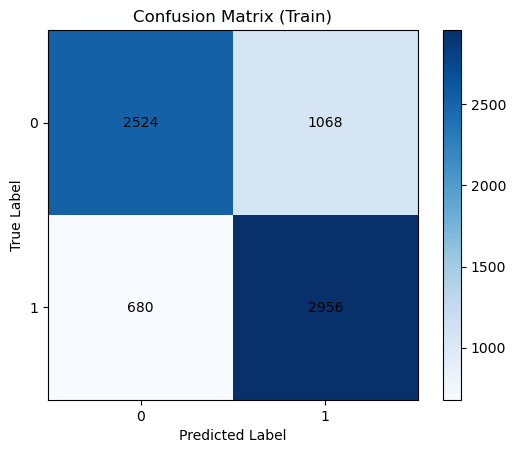

In [16]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm_train, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Train)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        plt.text(j, i, cm_train[i, j], ha="center", va="center", color="black")

#### 평가 데이터를 활용한 confusion matrix

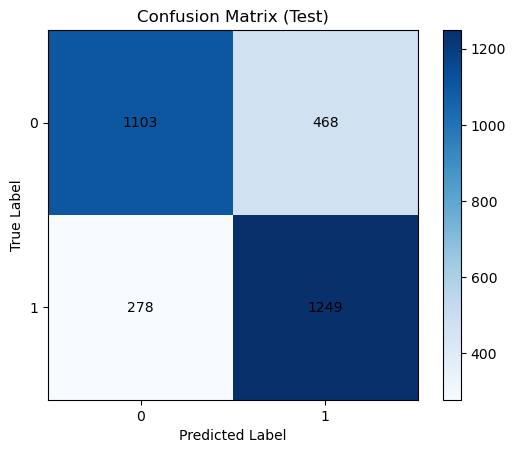

In [17]:
plt.imshow(cm_test, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        plt.text(j, i, cm_test[i, j], ha="center", va="center", color="black")

In [18]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
print(f'Logistic Regression train의 P,R,F1 : {precision_train:.2f} / {recall_train:.2f} / {f1_train:.2f}')

precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f'Logistic Regression test의 P,R,F1 : {precision_test:.2f} / {recall_test:.2f} / {f1_test:.2f}')

Logistic Regression train의 P,R,F1 : 0.73 / 0.81 / 0.77
Logistic Regression test의 P,R,F1 : 0.73 / 0.82 / 0.77


#### AUC 구하기

In [19]:
from sklearn.metrics import roc_auc_score

# 클래스 확률을 예측합니다
y_prob = logistic_reg.predict_proba(X_test)[:, 1] # 클래스 1의 확률을 사용합니다

# AUC를 계산합니다
auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc:.2f}%')

AUC: 0.84%


#### LR에서 계수의 영향 정도 파악 - 변수 뽑는데 사용

In [35]:
coeff_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': logistic_reg.coef_.flatten()})

# 계수의 절대값을 기준으로 내림차순 정렬
coeff_df['abs_coefficient'] = coeff_df['coefficient'].abs()
coeff_df_sorted = coeff_df.sort_values(by='abs_coefficient', ascending=False)

# 변수의 영향력을 확인
coeff_df_sorted['feature'][:8]

0                         tenure
3    InternetService_Fiber optic
1                       Contract
2                   PhoneService
5                   TotalCharges
4             InternetService_No
6               PaperlessBilling
7                 MonthlyCharges
Name: feature, dtype: object

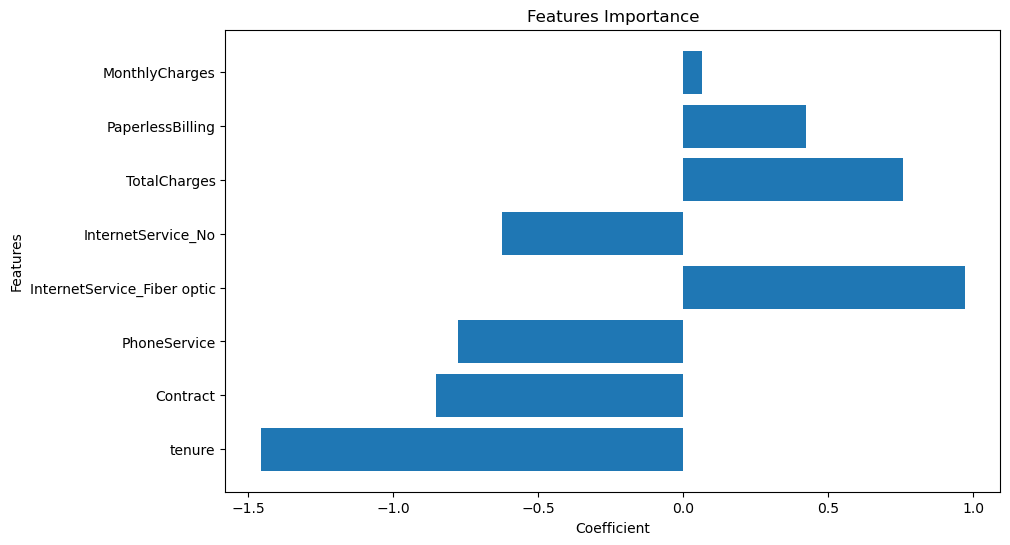

In [36]:
# 변수 영향력 시각화
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, logistic_reg.coef_.flatten())
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Features Importance')
plt.show()

#### 최적 파라미터 찾아서 진행

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(solver='saga', multi_class='auto', max_iter=10)
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(model, param_grid, cv=100, scoring='accuracy')
grid_search.fit(X, y)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn

GridSearchCV(cv=100, estimator=LogisticRegression(max_iter=10, solver='saga'),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [38]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 0.01, 'penalty': 'l1'}
Best cross-validation score: 1.00


### LightGBM

In [42]:
from lightgbm import LGBMClassifier

In [43]:
X.columns

Index(['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges', 'internet_cnt',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'PaperlessBilling',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Contract'],
      dtype='object')

#### 다중 공선성 파악 후 10 이상은 버리기

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = telco_fe_1.columns
vif_data["VIF"] = [variance_inflation_factor(telco_fe_1.values, i) for i in range(telco_fe_1.shape[1])]

# VIF 값이 10 미만인 변수만 필터링
filtered_vif = vif_data[vif_data["VIF"] > 10]

# 필터링된 변수명 출력
print("Selected features based on VIF < 10:\n", filtered_vif['feature'])

# 필터링된 변수명을 이용해 원 데이터프레임에서 해당 컬럼만 선택
selected_columns = filtered_vif['feature'].tolist()
selected_data = telco_fe_1[selected_columns]

NameError: name 'telco_fe_1' is not defined

#### Feature Engineering

In [45]:
tc = telco_customer[telco_customer['InternetService_No'] != 1]
InternetService_Yes = np.where(telco_customer['InternetService_No'] != 1, 1, 0)

In [46]:
telco_customer['InternetService_Yes'] = InternetService_Yes
telco_fe_1 = telco_customer.drop(['InternetService_DSL', 'InternetService_Fiber optic'], axis=1)

In [47]:
month_period = (telco_fe_1['TotalCharges'] / telco_fe_1['MonthlyCharges']).astype('int64')

In [48]:
telco_fe_1['Month_period'] = month_period
telco_fe_2 = telco_fe_1.drop(['TotalCharges'], axis=1)

In [49]:
# 새로 만든 변수 스케일링
from sklearn.preprocessing import StandardScaler

target = telco_fe_2['Month_period']
target_reshaped = target.values.reshape(-1, 1)
scaler = StandardScaler()

# 데이터에 fit하고 transform 수행
numeric_scaled = scaler.fit_transform(target_reshaped)
telco_fe_2['Month_period'] = pd.DataFrame(numeric_scaled, columns=scaler.get_feature_names_out())

In [50]:
# 새로 만든 변수 스케일링
from sklearn.preprocessing import StandardScaler

target = telco_fe_2['MonthlyCharges']
target_reshaped = target.values.reshape(-1, 1)
scaler = StandardScaler()

# 데이터에 fit하고 transform 수행
numeric_scaled = scaler.fit_transform(target_reshaped)
telco_fe_2['MonthlyCharges'] = pd.DataFrame(numeric_scaled, columns=scaler.get_feature_names_out())

##### internetservice yes 여부 확인

In [ ]:
in_customer['InternetService_DSL'].value_counts()

In [ ]:
out_customer['InternetService_DSL'].value_counts()

In [ ]:
in_customer['InternetService_Fiber optic'].value_counts()

In [ ]:
out_customer['InternetService_Fiber optic'].value_counts()

#### train, test split

In [51]:
# X = pd.concat([numeric_df, category_df, time_df], axis=1)
X = telco_fe_2.drop(['Churn'], axis=1)
X_clean = X[['tenure', 'MonthlyCharges', 'internet_cnt', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'InternetService_No', 'InternetService_Yes', 'PaperlessBilling',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Contract', 'Month_period']]
y = y_column

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

In [52]:
lgbm_wrapper = LGBMClassifier(
    learning_rate=0.1,
    max_depth=-1,  # -1은 제한 없음을 의미
    n_estimators=1000,
    num_leaves=50,
    min_child_samples=30,
)

evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, 
                 eval_metric='log_loss', 
                 eval_set=evals)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4161, number of negative: 4099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503753 -> initscore=0.015012
[LightGBM] [Info] Start training from score 0.015012


LGBMClassifier(min_child_samples=30, n_estimators=1000, num_leaves=50)

#### 분류모델 평가하기

In [53]:
# Acc 값
from sklearn.metrics import accuracy_score

y_train_pred = lgbm_wrapper.predict(X_train)
y_test_pred = lgbm_wrapper.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'학습 데이터를 이용한 Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 Acc 값 : {acc_test*100:.1f}%')

학습 데이터를 이용한 Acc 값 : 99.6%
평가 데이터를 이용한 Acc 값 : 89.4%


In [54]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
print(f'Logistic Regression train의 P,R,F1 : {precision_train:.2f} / {recall_train:.2f} / {f1_train:.2f}')

precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
print(f'Logistic Regression test의 P,R,F1 : {precision_test:.2f} / {recall_test:.2f} / {f1_test:.2f}')

Logistic Regression train의 P,R,F1 : 0.99 / 1.00 / 1.00
Logistic Regression test의 P,R,F1 : 0.85 / 0.96 / 0.90


In [55]:
# AUC
from sklearn.metrics import roc_auc_score

y_prob = lgbm_wrapper.predict_proba(X_test)[:, 1] # 클래스 1의 확률을 사용합니다

auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc:.2f}%')

AUC: 0.95%


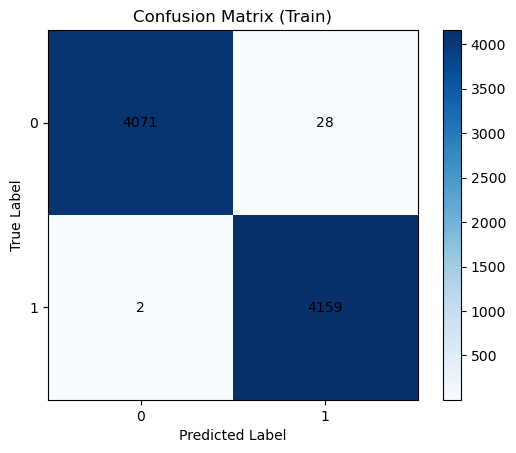

In [56]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.imshow(cm_train, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Train)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        plt.text(j, i, cm_train[i, j], ha="center", va="center", color="black")

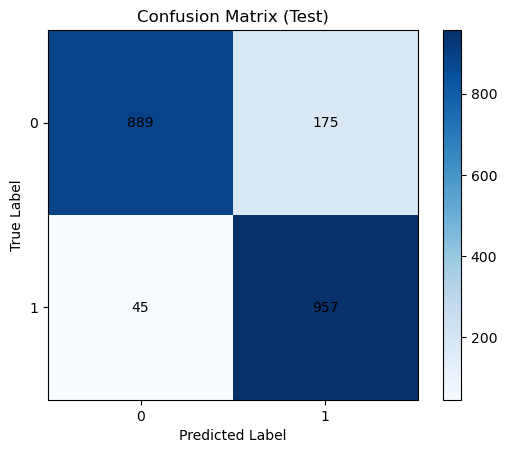

In [57]:
plt.imshow(cm_test, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        plt.text(j, i, cm_test[i, j], ha="center", va="center", color="black")

#### Feature Importance 확인

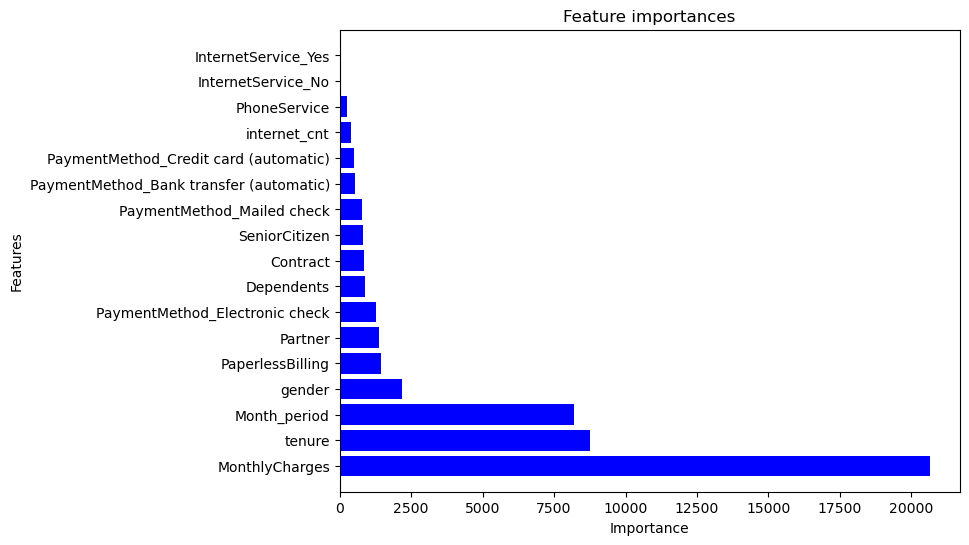

In [60]:
# 특성 중요도 추출
importances = lgbm_wrapper.feature_importances_

# 특성 이름
feature_names = X_clean.columns

# 특성 중요도를 내림차순으로 정렬
indices = np.argsort(importances)[::-1]

# 중요도 순으로 특성 이름 정렬
sorted_feature_names = [feature_names[i] for i in indices]

# 특성 중요도 그래프로 표현
plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.barh(range(len(importances)), importances[indices], color='b', align='center')
plt.yticks(range(len(importances)), sorted_feature_names)
plt.ylim([-1, len(importances)])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

#### 최적 하이퍼 파라미터 구하기

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=42, force_row_wise=True)
param_grid = {
    'num_leaves': [20, 50, 100],
    'min_data_in_leaf': [30, 50, 70],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 70, 100]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [War

In [ ]:
print("Best parameters found: ", grid.best_params_)
print("Best accuracy found: ", grid.best_score_)